In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

CPU times: user 1.17 s, sys: 367 ms, total: 1.54 s
Wall time: 2.47 s


In [4]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 64, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 64, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(64, 64, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(64, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

BATCH_SIZE=3000
GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 64, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(64, 64, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([64, 32, 8])
torch.Size([64])
torch.Size([64, 32, 8])
torch.Size([64])
torch.Size([64, 64, 8])
torch.Size([64])
torch.Size([64, 32,

In [5]:
GEN.load_state_dict(torch.load("GEN_WEIGHT.pkl"))

In [6]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

In [19]:
%%time
class Waveform():
    
    def __init__(self, path=None, select=1, select2=1):
        if path is None:
            raise ValueError("Insert file path!")
        if select is None:
            raise ValueError("Pick 1 or 2!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,pedestal,pedestal_sum
        initial = waveform_n[label==select]
        del waveform_n, label
        self.waveform = initial[label2==select2]
        del initial, label2
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root",select=4)

CPU times: user 44.9 s, sys: 4.28 s, total: 49.2 s
Wall time: 54.8 s


In [20]:
print(len(dataset))
data_loader = DataLoader(dataset=dataset,
                         batch_size=2550,
                         shuffle=False,
                         num_workers=3)
del dataset

28045


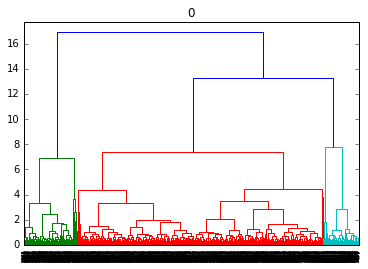

[1 2 3]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


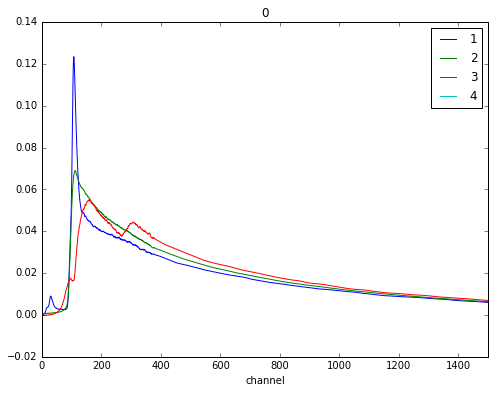

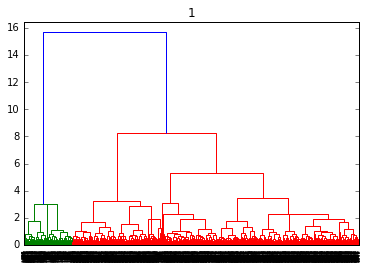

[1 2 3]


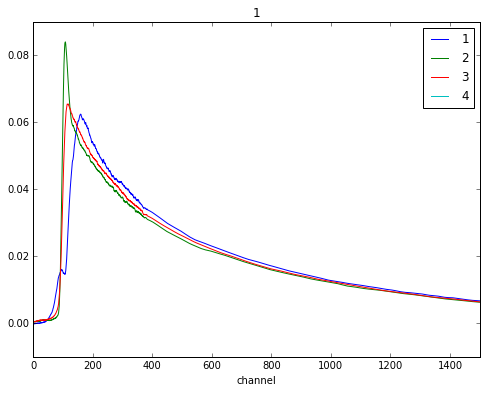

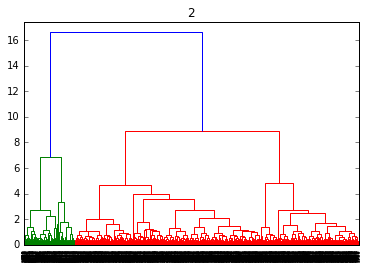

[1 2 3]


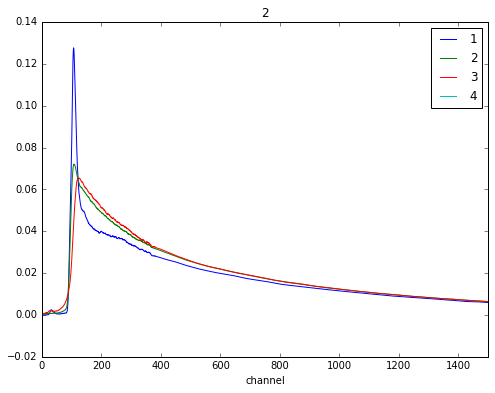

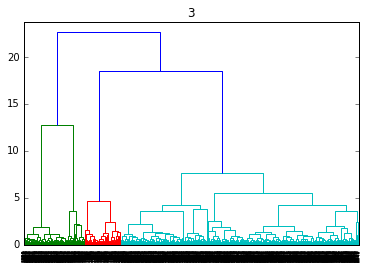

[1 2 3 4]


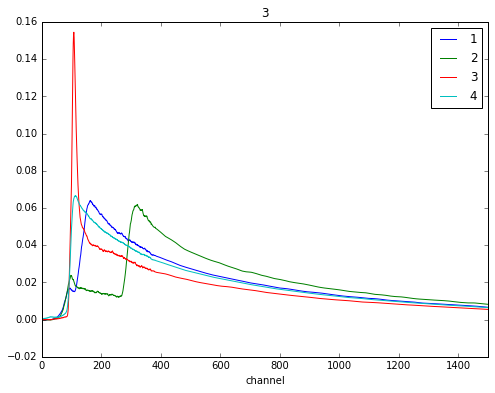

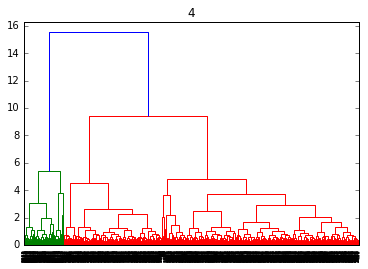

[1 2 3]


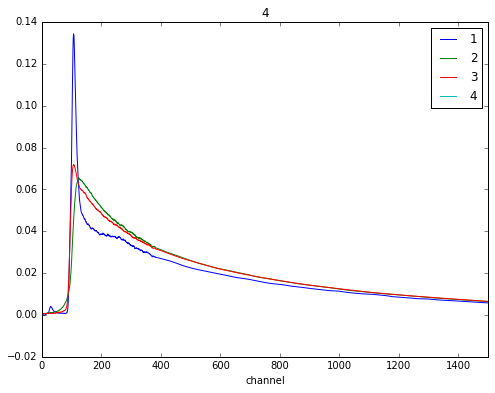

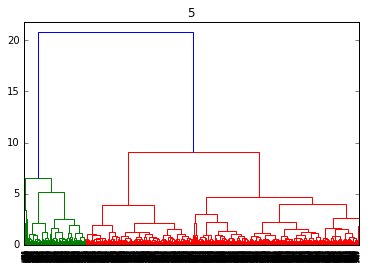

[1 2 3]


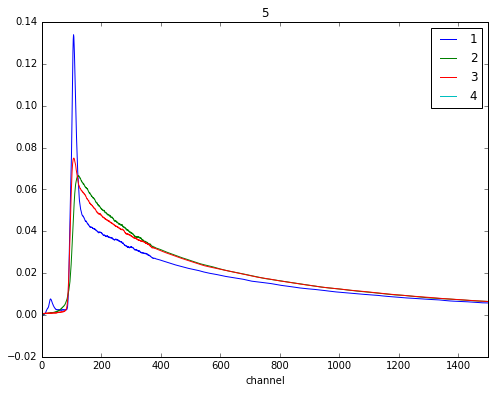

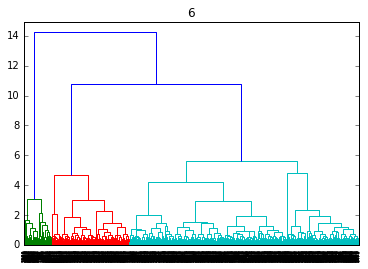

[1 2 3]


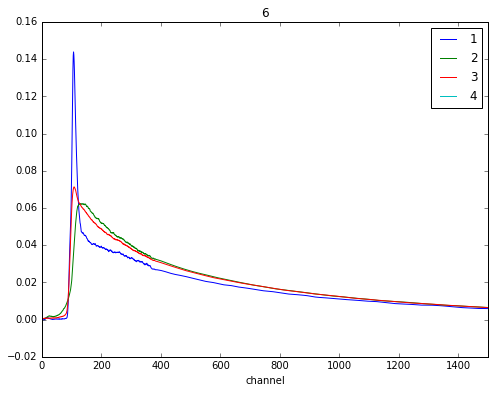

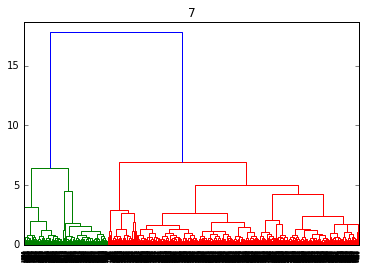

[1 2]


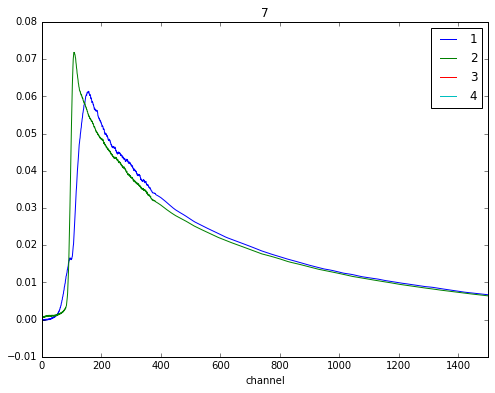

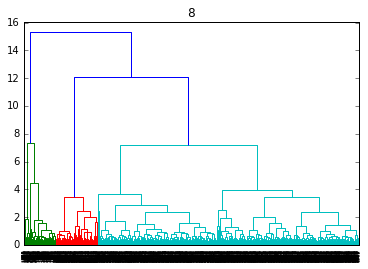

[1 2 3]


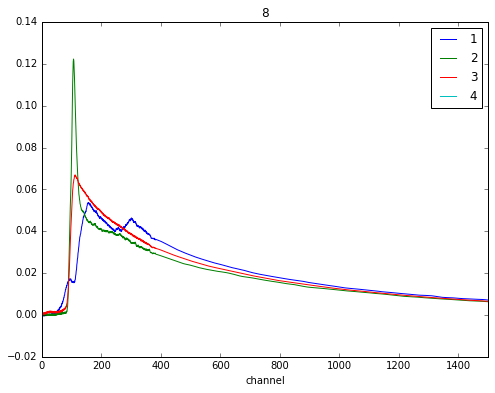

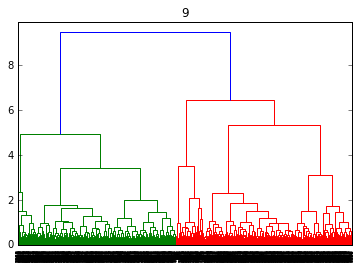

[1 2]


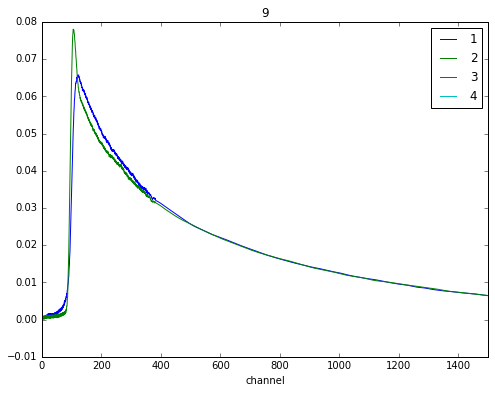

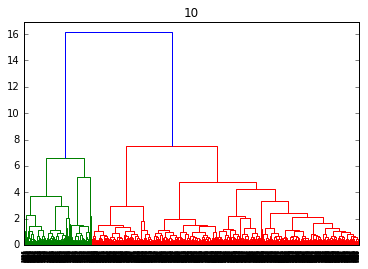

[1 2]


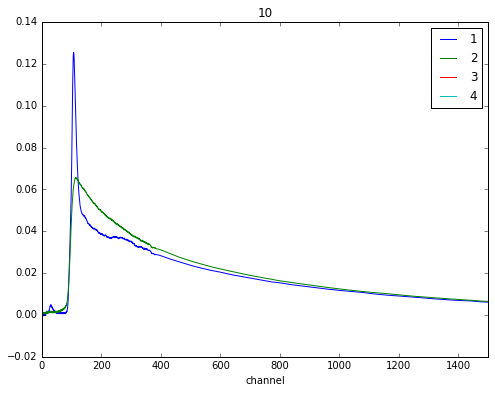

CPU times: user 4min 17s, sys: 29.9 s, total: 4min 47s
Wall time: 4min 34s


In [22]:
%%time

exclude = []

try:
    for batch_number, waveform in enumerate(data_loader):
        
        average = []
        average2 = []
        average3 = []
        average4 = []
        
        batch_size = waveform.size()[0]
        plotter = waveform.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
#         print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
        fig = plt.figure(figsize=(6, 4))
        dn = dendrogram(Z)
        plt.title("{}".format(batch_number))
        plt.show()
        
        clusters = fcluster(Z, 8, criterion='distance')
        print(np.unique(clusters))
        exclude.append(clusters)
        
        
        for i, waveform_out in enumerate(features[0]):
#             plt.figure(figsize=(6, 4))
#             plt.plot(plotter[i])
#             plt.show()
            if clusters[i]==1:
                average.append(plotter[i])
                
            if clusters[i]==2:
                average2.append(plotter[i])
            
            if clusters[i]==3:
                average3.append(plotter[i])
                
            if clusters[i]==4:
                average4.append(plotter[i])
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
        plt.plot(dang3,label="3")
        plt.plot(dang4,label="4")
        plt.xlim(0,1500)
        plt.xlabel("channel")
        plt.legend()
        plt.title(batch_number)
        plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')

# Exclude LS-like, have to manually choose each time (Data shuffles every time when runs)

In [27]:
remain = np.ones(28045)
picked = np.array([2,3,2,4,3,3,3,2,3,0,2])

# I choose zeros to survives
for i,k in enumerate(exclude):
    for j in range(len(k)):
        if picked[i]==exclude[i][j]:
            remain[(i*2550+j)] = 0
        if picked[i]==0:
            remain[(i*2550+j)] = 0
survives = remain.astype(int)
print(survives)

[1 0 0 ... 0 0 0]


In [28]:
np.save("survives",survives)